# Gradient Boosted Trees / Gradient Boosted Classifier (GBT)

In [35]:
# Imports
import tensorflow as tf
import keras_tuner as kt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.preprocessing import *

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from skl2onnx import update_registered_converter
from skl2onnx.common.data_types import guess_numpy_type
from skl2onnx.algebra.onnx_ops import (
    OnnxSub, OnnxMatMul, OnnxGemm)
from skl2onnx import to_onnx, get_model_alias
import sclblonnx as so
from mlprodict.onnxrt import OnnxInference
from onnxruntime import InferenceSession
import onnx_graphsurgeon as gs
import tf2onnx

from onnx import *
from onnx import version_converter
from onnx_tf.backend import prepare

import pickle
import sys
import joblib
import os

In [36]:
# Constants

# Image size
IMAGE_SIZE = [32, 32]

## Step 02: Data Understanding

In [37]:
# Read in the dataframe with the labelled data
df = pd.read_json('../data/labelled_data/whole_data_1637521796.json', orient='records')

In [38]:
# Show amount of samples and the first data samples
print("Amount of samples:", df.shape[0])
df.head(n=3)

Amount of samples: 200


,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,Human
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,Human
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,Ambigous heat


## Step 03: Data Preparation

## Binary Classification

### Data Preparation

In [39]:
# Convert multilclass labels to binary labels
binary_label_converter = { 
    'Human': 1,
    'Several humans': 1, 
    'Non-human heat': 0, 
    'Ambigous heat': 0,
    'No heat':  0,
}


df_binary = df.copy()

df_binary['label'] = df_binary['label'].apply(lambda x: binary_label_converter[x])
df_binary.head(n=3)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,0


In [40]:
# Prepare the data
y = df_binary['label'].to_numpy()
X = np.array(df_binary['data'].to_list())
X = np.expand_dims(X, axis=3)

# Print the shapes
print(y.shape)
print(X.shape)

(200,)
(200, 32, 32, 1)


In [41]:
# Create train / val / test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Print the data shape
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(160, 32, 32, 1)
(160,)
(40, 32, 32, 1)
(40,)


## Multiclass Classification

### Data Preparation

In [42]:
# Convert multilclass labels to integer labels
multiclass_label_converter = { 
    'Human': 0,
    'Several humans': 1, 
    'Non-human heat': 2, 
    'Ambigous heat': 3,
    'No heat':  4
}


df_mc = df.copy()

df_mc['label'] = df_mc['label'].apply(lambda x: multiclass_label_converter[x])
df_mc.head(n=3)

,index,Timestamp,Sensor ID,Room Temperature,RSSI,data,changed,label
521,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,0
2940,2940,2021-05-07 13:10:22,3078,22.400000,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,0
226,226,2021-05-07 13:05:55,3078,21.100000,-68,"[[11.5, 10.5, 12.0, 12.5, 12.6, 13.0, 12.6, 12...",True,3


In [43]:
# Prepare the data
y_mc = df_mc['label'].to_numpy()
label_binarizer = LabelBinarizer()
label_binarizer.fit(range(max(y_mc)+1))
y_mc_onehot = label_binarizer.transform(y_mc)

X_mc = np.array(df_mc['data'].to_list())
X_mc = np.expand_dims(X_mc, axis=3)

assert np.all(np.sum(y_mc_onehot, axis=1) == 1)

# Print the shapes and one label example
print(X_mc.shape)
print(y_mc_onehot.shape)
print(y_mc_onehot[:1])

(200, 32, 32, 1)
(200, 5)
[[1 0 0 0 0]]


In [44]:
# Create train / val / test split
X_mc_train, X_mc_test, y_mc_train, y_mc_test = train_test_split(X_mc, y_mc_onehot, test_size=0.2, random_state=0)

# Print the data shape
print(X_mc_train.shape)
print(y_mc_train.shape)
print(X_mc_val.shape)
print(y_mc_val.shape)

(160, 32, 32, 1)
(160, 5)
(15, 32, 32, 1)
(15, 5)


## Step 03: Modelling

## Feature Generator

### Feature Generator Model

The feature generator model is a simple CNN model that is used to generate and extract the features needed for the later classification from the images. It uses stacked convolutional layers that yield $1x1$ feature maps that are then used by the gradient boosted classifiers. After training, the convolutional layers are taken and put in a separate model for inference ("feature generator model").

In [45]:
# Simple CNN model with mutiple, stacked convolutional layers

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # Input is 32x32 pixels RGB
y = tf.keras.layers.Conv2D(kernel_size=3, filters=4, strides=(2,2), padding='same', use_bias=True, activation='relu')(x) # 32x32 -> 16x16
y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 16x16 -> 8x8
y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 8x8 -> 4x4
y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 4x4 -> 2x2
y = tf.keras.layers.Conv2D(kernel_size=3, filters=512, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 2x2 -> 1x1
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dense(32)(y)
y = tf.keras.layers.Dropout(0.2)(y)
y = tf.keras.layers.Dense(2, activation='softmax')(y)

model = tf.keras.Model(x, y,name="feature_generator")


model.compile(
optimizer='adam',
loss= 'sparse_categorical_crossentropy',
metrics=['accuracy'])
model.build(input_shape=(None, 32, 32, 1))
model.summary()

Model: "feature_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 4)         40        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 8)           296       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 8)           584       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 2, 2, 8)           584       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 512)         37376     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)         

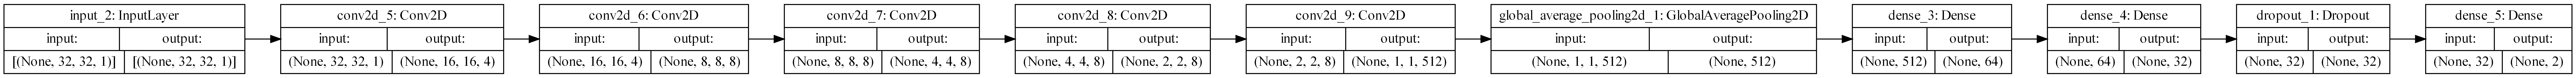

In [46]:
# Model plot
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(model, to_file = "feature_generator_CNN.png", show_shapes=True, rankdir="LR", dpi=400)

### Training of the Feature Generator Model

Epoch 1/20
20/20 [==============================] - 1s 19ms/step - loss: 0.7034 - accuracy: 0.5500 - val_loss: 0.6515 - val_accuracy: 0.6500
Epoch 2/20
20/20 [==============================] - 0s 15ms/step - loss: 0.6714 - accuracy: 0.6187 - val_loss: 0.6443 - val_accuracy: 0.6500
Epoch 3/20
20/20 [==============================] - 0s 9ms/step - loss: 0.6684 - accuracy: 0.6187 - val_loss: 0.6572 - val_accuracy: 0.6500
Epoch 4/20
20/20 [==============================] - 0s 9ms/step - loss: 0.6349 - accuracy: 0.6187 - val_loss: 0.6297 - val_accuracy: 0.7000
Epoch 5/20
20/20 [==============================] - 0s 9ms/step - loss: 0.5724 - accuracy: 0.7063 - val_loss: 0.6352 - val_accuracy: 0.6750
Epoch 6/20
20/20 [==============================] - 0s 9ms/step - loss: 0.5195 - accuracy: 0.7563 - val_loss: 0.7119 - val_accuracy: 0.7500
Epoch 7/20
20/20 [==============================] - 0s 9ms/step - loss: 0.5314 - accuracy: 0.7375 - val_loss: 0.7040 - val_accuracy: 0.7500
Epoch 8/20
20/20 [

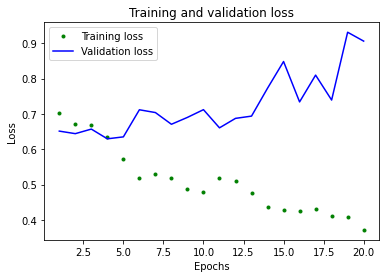

In [47]:
# Fit the model

# Training parameters
EPOCHS = 20
BATCH_SIZE = 8

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training history
plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Hyperparameter Tuning of the Feature Generator Model

In [48]:
# Hyperparameter tuning of the feature generator model

# Define the maximum number of hyperparameter tuning trials
MAX_TRIALS = 20


# Create an own tuner class which inherits from bayesian optimization for hyperparameter tuning
class SimpleTuner(kt.tuners.BayesianOptimization):

    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', min_value=2, max_value=32, step=2, default=8)
        kwargs['epochs'] = trial.hyperparameters.Int('num_epochs', min_value=5, max_value=40, step=5, default=10)
        return super(SimpleTuner, self).run_trial(trial, *args, **kwargs)

# Build the hypermodel of the feature generator
def build_feature_generator_hypermodel(hp):
    
    x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=4, strides=(2,2), padding='same', use_bias=True, activation='relu')(x) # 32x32 -> 16x16
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 16x16 -> 8x8
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 8x8 -> 4x4
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 4x4 -> 2x2
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=512, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 2x2 -> 1x1
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Dense(64)(y)
    y = tf.keras.layers.Dense(32)(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Dense(2, activation='softmax')(y)

    model = tf.keras.Model(x, y,name="feature_generator_hypermodel")

    model.compile(optimizer=tf.keras.optimizers
                  .Adam(learning_rate=hp.Float('learning_rate', min_value=0.5e-03, max_value=2e-03, default=1e-03)),
                  loss= 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Generate an instance of the tuner
tuner = SimpleTuner(build_feature_generator_hypermodel,
                    objective='val_accuracy',
                    max_trials=MAX_TRIALS,
                    metrics=['accuracy'],
                    max_model_size=None,
                    directory=".",
                    project_name="feature_generator_hypertuning",
                    logger=None)

# Do the hyperparameter tuning
tuner.search(X_train, y_train, validation_data=(X_val, y_val))

# Prints out the summary of hyperparameter tuning
tuner.results_summary()

# Get the best model of all the created models during hyperparameter tuning
model = tuner.get_best_models()[0]


INFO:tensorflow:Reloading Oracle from existing project .\feature_generator_hypertuning\oracle.json
INFO:tensorflow:Reloading Tuner from .\feature_generator_hypertuning\tuner0.json
INFO:tensorflow:Oracle triggered exit
Results summary
Results in .\feature_generator_hypertuning
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.0016825450897121922
batch_size: 32
num_epochs: 30
Score: 0.800000011920929
Trial summary
Hyperparameters:
learning_rate: 0.002
batch_size: 32
num_epochs: 40
Score: 0.800000011920929
Trial summary
Hyperparameters:
learning_rate: 0.0019227410432447738
batch_size: 8
num_epochs: 10
Score: 0.800000011920929
Trial summary
Hyperparameters:
learning_rate: 0.001993471907262864
batch_size: 18
num_epochs: 40
Score: 0.800000011920929
Trial summary
Hyperparameters:
learning_rate: 0.0017135332247275486
batch_size: 10
num_epochs: 15
Score: 0.800000011920929
Trial summary
Hyperparameters:
learning_rate: 0.0005
ba

### Build Feature Generator Model from Convolutional Layers as Separate Model 

In [49]:
# Get different stacks of convolutional layers from the trained CNN model and put them into separate model instances

def get_conv_layer_list(model):
    
    conv_layer_list = []
        
    for i in range(len(model.layers)):
        layer = model.layers[i]
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        
        # Get the layer input and output
        inputs = model.inputs
            
        if i==len(model.layers):
            outputs = model.outputs
        else:
            outputs = model.layers[i].output
        
        current_conv_layer = tf.keras.Model(name=layer.name, inputs=inputs, outputs=model.layers[i].output)
        conv_layer_list.append(current_conv_layer)
    
    return conv_layer_list

In [50]:
# Get the last element from the list wbich is a model with all convolutional layers
feature_generators_list = get_conv_layer_list(model)
feature_generator_convs = feature_generators_list[-1]

# Create a new model with a reshape layer at the end
feature_generator = tf.keras.models.Sequential(name="feature_generator_conv")
feature_generator.add(feature_generator_convs)
feature_generator.add(tf.keras.layers.Reshape([512]))

# Plot the model summary
feature_generator.build(input_shape=(32, 32, 1))
feature_generator.summary()

Model: "feature_generator_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Functional)        (None, 1, 1, 512)         38880     
_________________________________________________________________
reshape (Reshape)            (None, 512)               0         
Total params: 38,880
Trainable params: 38,880
Non-trainable params: 0
_________________________________________________________________


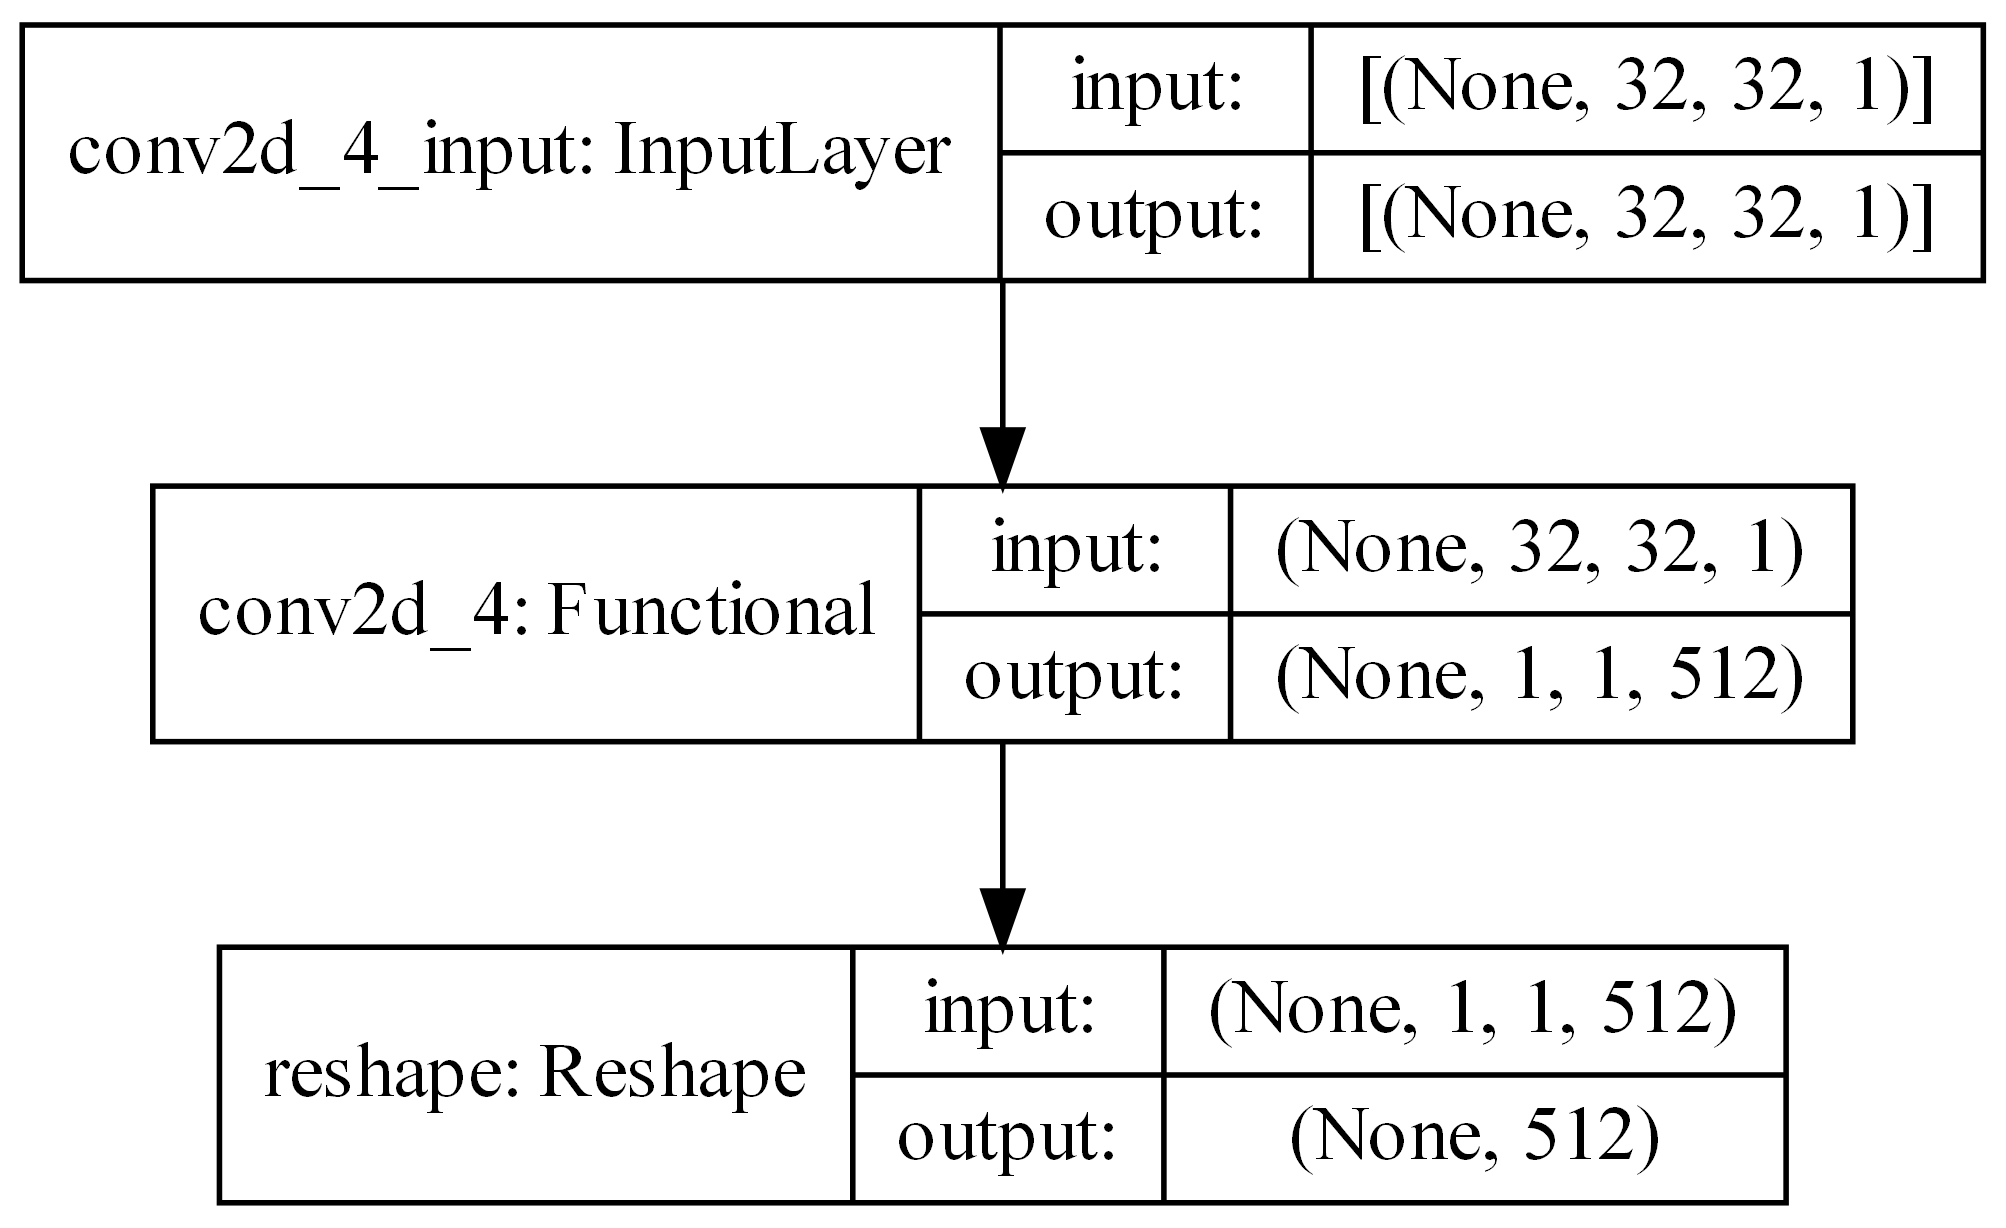

In [51]:
# Plot the feature generator model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(feature_generator, to_file="feature_generator_model.png", show_shapes=True, rankdir="TB", dpi=400)

### Generate the Features for the Whole Dataset

In [52]:
# Generate the features with the feature generate model by calling the predict method
features = feature_generator.predict(X)
print(features.shape)

(200, 512)


### Save the Feature Generator Model

In [53]:
# Save the feature generator model in various different formats

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(feature_generator) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('feature_generator.tflite', 'wb') as f:
  f.write(tflite_model)


# Save the model as onnx model
tf2onnx.convert.from_keras(feature_generator, output_path="feature_generator.onnx", opset=8)


# Save as keras model
feature_generator.save("feature_generator.h5")

print("Models saved successfully.")

INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmpxulnal0r\assets
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Models saved successfully.


## Classifier Modelling

### Helpful Functions for Classifiers

In [54]:
# Get the model size in kiB
def get_memory_size(clf, feature_generator, fname_clf = "clf_dump", fname_fg="feature_generator_dump"):
    
    # Get the size of the feature generator
    joblib.dump(feature_generator, fname_fg)
    fg_size = os.path.getsize(fname_fg)
    fg_size = fg_size / 1024
    print(f"Feature Generator size in kiB: {fg_size}")
    
    # Get the size of the classifier
    joblib.dump(clf, fname)
    clf_size = os.path.getsize(fname)
    clf_size = clf_size / 1024
    print(f"CLF size in kiB: {clf_size}")

    # Total size for GBT in kiB
    print(f"Total size in kiB (without model conversion): {fg_size + clf_size}")

### Prepare Data for Classifier

In [55]:
# Add the generated features as extra columns to the data
df_train_binary_expanded = pd.DataFrame(np.concatenate([df_binary.head(X.shape[0]), feature_generator.predict(X)], axis=1))

# Show the data
df_train_binary_expanded.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,510,511,512,513,514,515,516,517,518,519
0,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,1,0.0,0.0,...,0.1162,0.0,0.0,0.0,0.0,0.039633,0.037273,0.0,0.0,0.02171
1,2940,2021-05-07 13:10:22,3078,22.4,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,1,0.0,0.0,...,0.106629,0.0,0.0,0.0,0.0,0.050768,0.040025,0.0,0.0,0.004339


In [56]:
# Prepare the data for gradient boosting
y_clf = df_train_binary_expanded[7].to_numpy().astype(int)
X_clf= df_train_binary_expanded.iloc[:,8:].to_numpy()
print(y_clf.shape)
print(X_clf.shape)

(200,)
(200, 512)


In [57]:
# Create train / test split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.1, random_state=0)

# Print the data shape
print(X_train_clf.shape)
print(y_train_clf.shape)
print(X_test_clf.shape)
print(y_test_clf.shape)

(180, 512)
(180,)
(20, 512)
(20,)


### Simple GBT Classifier

Train Accuracy: 0.9944444444444445
Test Accuracy:  0.6
Ground Truth (Test):      [1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0]
Prediction (Test):        [1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1]


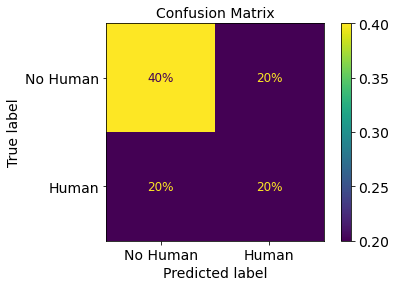

In [84]:
# Train the GBT
clf = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=3, random_state=0).fit(X_train_clf, y_train_clf)

# Mean train accuracy
train_acc = clf.score(X_train_clf, y_train_clf)
print(f"Train Accuracy: {train_acc}")

# Mean test accuracy
test_acc = clf.score(X_test_clf, y_test_clf)
print(f"Test Accuracy:  {test_acc}")

# Get prediction
y_pred = clf.predict(X_test_clf)

# Ground truth and predicted labels
print(f"Ground Truth (Test):      {y_test_clf}")
print(f"Prediction (Test):        {y_pred}")

# Calculate and display the confusion matrix
conf_mat = confusion_matrix(y_test_clf, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["No Human", "Human"])
disp.plot(values_format=".0%")
plt.title("Confusion Matrix")
# Change the font sizes of the plot
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('figure', titlesize=18)  # fontsize of the figure title
# Save and show the plot
plt.savefig("confusion_matrix_simple_gbt.png", dpi=400)
plt.show()

### Hyperparameter Tuning for GBT

In [62]:
# HP-Tuning

# Maximum number of features to reduce the model size
MAX_FEATURES = 150

# Define the hypermodel
def build_gbt_hypermodel(hp):
    
    n_estimators = hp.Int("n_estimators", 10, 100)
    learning_rate = hp.Float("learning_rate", 0.1, 1.0)
    max_depth = hp.Int("max_depth", 1, 4)
    max_features = hp.Int("max_features", 1, MAX_FEATURES)
    
    return GradientBoostingClassifier(n_estimators=n_estimators,
                                      learning_rate=learning_rate, 
                                      max_depth=max_depth,
                                      max_features=max_features,
                                      validation_fraction=0.2,
                                      random_state=0)

In [63]:
# Number of hyperparameter tuning trials
MAX_TRIALS = 20

# Instaniate a tuner class instance
tuner = kt.tuners.SklearnTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('score', 'max'),
        max_trials=MAX_TRIALS),
    hypermodel=build_gbt_hypermodel,
    scoring=skl.metrics.make_scorer(skl.metrics.balanced_accuracy_score),
    metrics=[skl.metrics.accuracy_score],
    cv=skl.model_selection.StratifiedKFold(5),
    directory='.',
    project_name='hp_tuning_gbt')



tuner.search(X_train_clf, y_train_clf)

best_clf = tuner.get_best_models(num_models=1)[0]

print(f"Best model test score: {best_clf.score(X_test_clf, y_test_clf)}")

print(f"Best model params: {best_clf.get_params()}")

INFO:tensorflow:Reloading Oracle from existing project .\hp_tuning_gbt\oracle.json


INFO:tensorflow:Reloading Oracle from existing project .\hp_tuning_gbt\oracle.json


INFO:tensorflow:Reloading Tuner from .\hp_tuning_gbt\tuner0.json


INFO:tensorflow:Reloading Tuner from .\hp_tuning_gbt\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Best model test score: 0.35
Best model params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.9971538144665033, 'loss': 'deviance', 'max_depth': 3, 'max_features': 34, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 87, 'n_iter_no_change': None, 'random_state': 0, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.2, 'verbose': 0, 'warm_start': False}


Train Accuracy: 0.38333333333333336
Test Accuracy:  0.35
Ground Truth (Test): [1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0]
Prediction (Test):   [1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1]


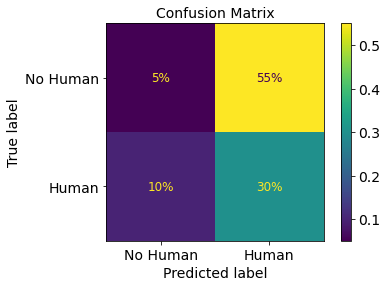

In [83]:
# Compare predictions and ground truth on testing set
y_pred = best_clf.predict(X_test_clf)

# Mean train accuracy
train_acc = best_clf.score(X_train_clf, y_train_clf)
print(f"Train Accuracy: {train_acc}")

# Mean test accuracy
test_acc = best_clf.score(X_test_clf, y_test_clf)
print(f"Test Accuracy:  {test_acc}")

# Ground truth and predicted labels
print(f"Ground Truth (Test): {y_test_clf}")
print(f"Prediction (Test):   {y_pred}")

# Calculate and display the confusion matrix
conf_mat = confusion_matrix(y_test_clf, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["No Human", "Human"])
disp.plot(values_format=".0%")
plt.title("Confusion Matrix")
# Change the font sizes of the plot
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('figure', titlesize=18)  # fontsize of the figure title
# Save and show the plot
plt.savefig("confusion_matrix_hp-tuning_gbt.png", dpi=400)
plt.show()



#### Save ONNX model

In [197]:
# Convert model to onnx-format and save it
initial_type = [('float_input', FloatTensorType([None, 4]))]
onnx = convert_sklearn(best_clf, initial_types=initial_type)
with open("best_gbt.onnx", "wb") as f:
    f.write(onnx.SerializeToString())


C:\Users\Felix\.conda\envs\ias0360-final-project\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The attribute `n_features_` is deprecated in 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


### Simple Support Vector Classifier (SVC)

Train Accuracy: 0.7222222222222222
Test Accuracy:  0.7
Ground Truth (Test): [1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0]
Prediction (Test):   [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


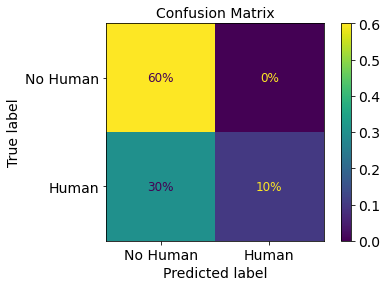

In [85]:
# Train the SVC
svc_clf = SVC()
svc_clf.fit(X_train_clf, y_train_clf)

# Mean train accuracy
train_acc = svc_clf.score(X_train_clf, y_train_clf)
print(f"Train Accuracy: {train_acc}")

# Mean test accuracy
test_acc = svc_clf.score(X_test_clf, y_test_clf)
print(f"Test Accuracy:  {test_acc}")

# Get the prediction
y_pred = svc_clf.predict(X_test_clf)

# Ground truth and predicted labels
print(f"Ground Truth (Test): {y_test_clf}")
print(f"Prediction (Test):   {y_pred}")

# Calculate and display the confusion matrix
conf_mat = confusion_matrix(y_test_clf, y_pred, normalize="all")
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["No Human", "Human"])
disp.plot(values_format=".0%")
plt.title("Confusion Matrix")
# Change the font sizes of the plot
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('figure', titlesize=18)  # fontsize of the figure title
# Save and show the plot
plt.savefig("confusion_matrix_simple_svc.png", dpi=400)
plt.show()



In [199]:
# Print the parameters of the classifier
print(svc_clf.get_params())

{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


####  Save as ONNX model

In [200]:
# Convert model to onnx-format and save it
onnx_svc_clf = to_onnx(svc_clf,  X_train_clf.astype(np.float32),
                    options={id(svc_clf): {'zipmap': False}},target_opset=6)
with open("simple_svc_clf.onnx", "wb") as f:
    f.write(onnx_svc_clf.SerializeToString())

#### Merge feature generator and classifier ONNX models to one model

In [201]:
# Name of the ONNX model files
model_file_1 = "feature_generator.onnx"
model_file_2 = "simple_svc_clf.onnx"


onnx_model_1 = load(model_file_1)
onnx_model_1 = version_converter.convert_version(onnx_model_1 , 6)

onnx_model_2 = load(model_file_2)
onnx_model_2 = version_converter.convert_version(onnx_model_2 , 6)

graph1 = gs.import_onnx(onnx_model_1)
for n in graph1.nodes:
    for cn in n.inputs:
        if cn.name[-1:] != 'a':
            cn.name = f'{cn.name}a'
        else:
            pass
    for cn in n.outputs:
        if cn.name[-1:] != 'a':
            cn.name = f'{cn.name}a'
        else:
            pass
graph1_inputs = [o.name for o in graph1.inputs]
print(f'graph1 inputs: {graph1_inputs}')
graph1_outputs = [i.name for i in graph1.outputs]
print(f'graph1 outputs: {graph1_outputs}')


graph2 = gs.import_onnx(onnx_model_2)
graph2_inputs = []
for n in graph2.nodes:
    for cn in n.inputs:
        if cn.name[-1:] != 'b':
            cn.name = f'{cn.name}b'
        else:
            pass
    for cn in n.outputs:
        if cn.name[-1:] != 'b':
            cn.name = f'{cn.name}b'
        else:
            pass
graph2_inputs = [i.name for i in graph2.inputs]
print(f'graph2 inputs: {graph2_inputs}')
graph2_outputs = [i.name for i in graph2.outputs]
print(f'graph2 outputs: {graph2_outputs}')


# Concatenate the two models
merged_model = so.concat(sg1=onnx_model_1.graph, sg2=onnx_model_2.graph)

# Save the merged model to file
so.graph_to_file(merged_model, "merged_model.onnx")

graph1 inputs: ['conv2d_4_inputa']
graph1 outputs: ['reshapea']
graph2 inputs: ['Xb']
graph2 outputs: ['labelb', 'probabilitiesb']


True

## Multiclass Classification

### Hyperparameter Tuning of the Feature Generator Model for Multiclass Labels

In [87]:
# Use oenhot encoding for training of feature generator
print(y_mc_train[-1])

[0 0 1 0 0]


In [88]:
# Hyperparameter tuning of the feature generator model

# Define the maximum number of hyperparameter tuning trials
MAX_TRIALS = 20

# Create an own tuner class which inherits from bayesian optimization for hyperparameter tuning
class SimpleTuner(kt.tuners.BayesianOptimization):

    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', min_value=2, max_value=32, step=2, default=8)
        kwargs['epochs'] = trial.hyperparameters.Int('num_epochs', min_value=5, max_value=40, step=5, default=10)
        return super(SimpleTuner, self).run_trial(trial, *args, **kwargs)

# Build the hypermodel of the feature generator
def build_feature_generator_mc_hypermodel(hp):
    
    x = tf.keras.layers.Input(shape=[*IMAGE_SIZE,1]) # input is 32x32 pixels RGB
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=4, strides=(2,2), padding='same', use_bias=True, activation='relu')(x) # 32x32 -> 16x16
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 16x16 -> 8x8
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 8x8 -> 4x4
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=8, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 4x4 -> 2x2
    y = tf.keras.layers.Conv2D(kernel_size=3, filters=512, strides=(2,2), padding='same', use_bias=True, activation='relu')(y) # 2x2 -> 1x1
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Dense(64)(y)
    y = tf.keras.layers.Dense(32)(y)
    y = tf.keras.layers.Dropout(0.2)(y)
    y = tf.keras.layers.Dense(5, activation='softmax')(y)

    model = tf.keras.Model(x, y,name="feature_generator_mc_hypermodel")

    model.compile(optimizer=tf.keras.optimizers
                  .Adam(learning_rate=hp.Float('learning_rate', min_value=0.5e-03, max_value=2e-03, default=1e-03)),
                  loss= 'categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Generate an instance of the tuner
tuner = SimpleTuner(build_feature_generator_mc_hypermodel,
                    objective='val_accuracy',
                    max_trials=MAX_TRIALS,
                    metrics=['accuracy'],
                    max_model_size=None,
                    directory=".",
                    project_name="feature_generator_mc_hypertuning",
                    logger=None)

# Do the hyperparameter tuning
tuner.search(X_mc_train, y_mc_train, validation_data=(X_mc_val, y_mc_val))

# Prints out the summary of hyperparameter tuning
tuner.results_summary()

# Get the best model of all the created models during hyperparameter tuning
model_mc = tuner.get_best_models()[0]


INFO:tensorflow:Reloading Oracle from existing project .\feature_generator_mc_hypertuning\oracle.json


INFO:tensorflow:Reloading Oracle from existing project .\feature_generator_mc_hypertuning\oracle.json


INFO:tensorflow:Reloading Tuner from .\feature_generator_mc_hypertuning\tuner0.json


INFO:tensorflow:Reloading Tuner from .\feature_generator_mc_hypertuning\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in .\feature_generator_mc_hypertuning
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
learning_rate: 0.001467373372571025
batch_size: 32
num_epochs: 40
Score: 0.6666666865348816
Trial summary
Hyperparameters:
learning_rate: 0.0013239220713018723
batch_size: 32
num_epochs: 25
Score: 0.6666666865348816
Trial summary
Hyperparameters:
learning_rate: 0.0017952100658536526
batch_size: 32
num_epochs: 40
Score: 0.6666666865348816
Trial summary
Hyperparameters:
learning_rate: 0.0014556301550496908
batch_size: 8
num_epochs: 10
Score: 0.6666666865348816
Trial summary
Hyperparameters:
learning_rate: 0.0010897323564889468
batch_size: 6
num_epochs: 15
Score: 0.6000000238418579
Trial summary
Hyperparameters:
learning_rate: 0.0005
batch_size: 2
num_epochs: 15
Score: 0.6000000238418579
Trial summary
Hyperparameters:
learning_rate: 0.001433926867706668
batch_size: 8
num_epochs: 15
Score: 0.6000000238418579
Trial summary
Hyperp

### Build Feature Generator Model from Convolutional Layers as Separate Model 

In [89]:
# Get the last element from the list wbich is a model with all convolutional layers
feature_generators_mc_list = get_conv_layer_list(model_mc)
feature_generator_mc_convs = feature_generators_mc_list[-1]

# Create a new model with a reshape layer at the end
feature_generator_mc = tf.keras.models.Sequential(name="feature_generator_mc_conv")
feature_generator_mc.add(feature_generator_mc_convs)
feature_generator_mc.add(tf.keras.layers.Reshape([512]))

# Plot the model summary
feature_generator_mc.build(input_shape=(32, 32, 1))
feature_generator_mc.summary()

Model: "feature_generator_mc_conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Functional)        (None, 1, 1, 512)         38880     
_________________________________________________________________
reshape (Reshape)            (None, 512)               0         
Total params: 38,880
Trainable params: 38,880
Non-trainable params: 0
_________________________________________________________________


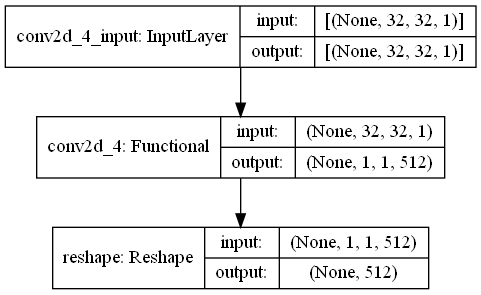

In [90]:
# Plot the feature generator model
# `rankdir='LR'` is to make the graph horizontal.
%matplotlib inline
tf.keras.utils.plot_model(feature_generator_mc, to_file="feature_generator_mc_model.png", show_shapes=True, rankdir="TB")

### Prepare Data for Classifier

In [91]:
# Add the generated features as extra columns to the data
df_train_mc_expanded = pd.DataFrame(np.concatenate([df_mc.head(X_mc.shape[0]), feature_generator_mc.predict(X)], axis=1))

# Show the data
df_train_mc_expanded.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,510,511,512,513,514,515,516,517,518,519
0,521,2021-05-07 13:06:24,3078,21.299999,-67,"[[12.0, 10.4, 11.1, 10.9, 10.9, 12.0, 11.6, 11...",True,0,0.0,0.016014,...,0.083757,0.0,0.0,0.029113,0.028078,0.0,0.0,0.0,0.0,0.033786
1,2940,2021-05-07 13:10:22,3078,22.4,-76,"[[11.8, 10.3, 11.2, 11.8, 10.6, 11.3, 11.4, 11...",True,0,0.0,0.009422,...,0.093765,0.0,0.0,0.039679,0.050312,0.0,0.0,0.0,0.0,0.032311


In [92]:
# Prepare the data for gradient boosting
y_mc_clf = df_train_mc_expanded[7].to_numpy().astype(int)
X_mc_clf= df_train_mc_expanded.iloc[:,8:].to_numpy()
print(y_mc_clf.shape)
print(X_mc_clf.shape)

(200,)
(200, 512)


In [93]:
# Create train / test split
X_mc_train_clf, X_mc_test_clf, y_mc_train_clf, y_mc_test_clf = train_test_split(X_mc_clf, y_mc_clf, test_size=0.1, random_state=0)

# Print the data shape
print(X_mc_train_clf.shape)
print(y_mc_train_clf.shape)
print(X_mc_test_clf.shape)
print(y_mc_test_clf.shape)

(180, 512)
(180,)
(20, 512)
(20,)


### Simple GBT Classifier 

Train Accuracy: 0.9666666666666667
Test Accuracy:  0.35
Ground Truth (Test): [0 2 3 3 0 0 2 3 0 2 2 3 2 0 2 0 0 2 0 3]
Prediction (Test):   [2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2]


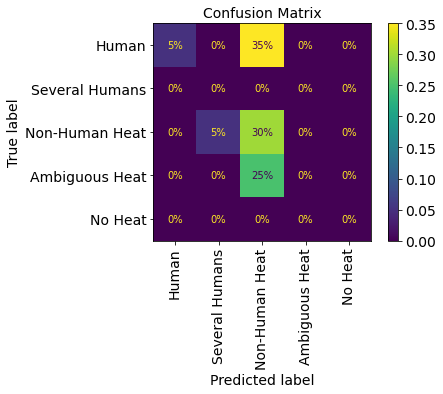

In [94]:
# Train the GBT
clf_mc = GradientBoostingClassifier(n_estimators=300, learning_rate=1.0, max_depth=3, random_state=0).fit(X_mc_train_clf, y_mc_train_clf)

# Mean train accuracy
train_acc = clf_mc.score(X_mc_train_clf, y_mc_train_clf)
print(f"Train Accuracy: {train_acc}")

# Get the prediction
y_mc_pred = clf_mc.predict(X_mc_test_clf)

# Mean test accuracy
test_acc = accuracy_score(y_mc_test_clf, y_mc_pred)
print(f"Test Accuracy:  {test_acc}")

# Ground truth and predicted labels
print(f"Ground Truth (Test): {y_mc_test_clf}")
print(f"Prediction (Test):   {y_mc_pred}")

# Calculate and display the confusion matrix
conf_mat = confusion_matrix(y_mc_test_clf, y_mc_pred, labels=[0, 1, 2, 3, 4], normalize="all")
disp = ConfusionMatrixDisplay(conf_mat, display_labels=["Human", "Several Humans", "Non-Human Heat", "Ambiguous Heat", "No Heat"])
disp.plot(values_format=".0%", xticks_rotation="vertical")
plt.title("Confusion Matrix")
# Change the font sizes of the plot
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('figure', titlesize=18)  # fontsize of the figure title
# Save and show the plot
plt.savefig("confusion_matrix_simple_gbt_mc.png", dpi=400, bbox_inches="tight")
plt.show()
